In [2]:
using Pkg
using Statistics
using Plots
using LinearAlgebra
using Distances
using StatsBase
using Distributions
using Random
using PyCall


function is_symmetric(adj)
    tf = isequal(adj,transpose(adj))
    if !tf
        println("Matrix is not symmetric!")
    end
    return tf
end


function make_iid_weighted_graph(nNodes)
    
    adj = rand(nNodes,nNodes)
    for i = 1:nNodes, j = 1:nNodes
        # symmetrize
        adj[j,i] = adj[i,j]
    end
    
    # Set diagonal to 0
    adj[diagind(adj)] .= 0
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    # Return adjacency matrix
    return adj
end
    

function make_random_geometric(nNodes,dims)
    
    # Generate random coordinates in [0,1)^dims
    randomCoordinates = rand(dims,nNodes)
    
    # Compute pairwise distances between nodes (points in [0,1)^dims)
    adj = pairwise(Euclidean(), randomCoordinates, dims = 2)
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end


function make_cosine_geometric(nNodes,dims)
    
    # Generate random coordinates in [0,1)^dims
    randomCoordinates = rand(dims,nNodes)
    
    # Compute pairwise distances between nodes (points in [0,1)^dims)
    adj = pairwise(CosineDist(), randomCoordinates, dims = 2)
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end

function make_ring_lattice_bin(nNodes,k)
    # Make ring lattice network in which each node has degree 2k
    
    # Initialize adj
    adj_a = zeros(nNodes,nNodes)
    
    # add k edges on the right of each node
    for ncol = 1:(nNodes-1)
        adj_a[(ncol+1):min((ncol+k),nNodes),ncol] .= 1
    end
    for ncol2 = (nNodes-k+1):nNodes
        for k1 = 1:k
            adj_a[ncol2,min(nNodes,(mod(ncol2+k1,nNodes+1)+1))] = 1
        end
    end
    
    # symmetrize
    adj = adj_a+transpose(adj_a)
    
    # binarize
    adj[adj .> 0] .= 1
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end


function make_ring_lattice_wei(nNodes)
    # Create weighted ring lattice
    
    if !iseven(nNodes)
        v = ones(1,(nNodes-1)) ./ [transpose(collect(1:floor(nNodes/2))) transpose(reverse(collect(1:floor(nNodes/2))))]
        v = [0 v]
        adj = deepcopy(v)
        for n in 1:(nNodes-1)
            adj = [adj; zeros(1,n) transpose(v[1,1:(nNodes-n)])]
        end
        adj = adj+transpose(adj)
        adj[diagind(adj)].=0
        
    else
        v = ones(1,(nNodes-1)) ./ [transpose(collect(1:(nNodes/2))) transpose(reverse(collect(1:(nNodes/2 - 1))))]
        v = [0 v]
        adj = deepcopy(v)
        for n in 1:(nNodes-1)
            adj = [adj; zeros(1,n) transpose(v[1,1:(nNodes-n)])]
        end
        adj = adj+transpose(adj)
        adj[diagind(adj)].=0
        
    end
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end


function make_dot_product(nNodes,dims)
    # Generate random coordinates in [0,1)^dims
    randomCoordinates = rand(dims,nNodes)
    
    # Compute pairwise distances between nodes (points in [0,1)^dims)
    adj = randomCoordinates' * randomCoordinates
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end


function make_dumb_2modular(nNodes,p_in,p_out)
    
    adj = zeros(nNodes,nNodes)
    
    community_assignments = [ones(1,Int(nNodes/2)) 2*ones(1,Int(nNodes/2))]
    
    for n1 in 1:nNodes
        for n2 in n1:nNodes
            
            if isequal(community_assignments[n1],community_assignments[n2])
                
                we = 0
                r = rand(1,1)[1]
                
                while r < p_in
                    we = we+1
                    r = rand(1,1)[1]
                end
                
                adj[n1,n2] = we
                adj[n2,n1] = we
                
            else
                
                we = 0
                r = rand(1,1)[1]
                
                while r < p_out
                    we = we+1
                    r = rand(1,1)[1]
                end
                
                adj[n1,n2] = we
                adj[n2,n1] = we
            end
            
        end
    end
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end

    
function make_dumb_4modular(nNodes,p_in,p_out)
    
    adj = zeros(nNodes,nNodes)
    
    community_assignments = [ones(1,Int(nNodes/4)) 2*ones(1,Int(nNodes/4)) 3*ones(1,Int(nNodes/4)) 4*ones(1,Int(nNodes/4))]
    
    for n1 in 1:nNodes
        for n2 in n1:nNodes
            
            if isequal(community_assignments[n1],community_assignments[n2])
                
                we = 0
                r = rand(1,1)[1]
                
                while r < p_in
                    we = we+1
                    r = rand(1,1)[1]
                end
                
                adj[n1,n2] = we
                adj[n2,n1] = we
                
            else
                
                we = 0
                r = rand(1,1)[1]
                
                while r < p_out
                    we = we+1
                    r = rand(1,1)[1]
                end
                
                adj[n1,n2] = we
                adj[n2,n1] = we
            end
            
        end
    end
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end



function make_dev_DiscreteUniform_configuration_model(nNodes,a,b)
    
    # Create a configuration model using the discrete uniform distribution between a and b.
    
    # Define distribution
    d = DiscreteUniform(a,b)
    strength_sequence = rand(d,nNodes)

    stubs = deepcopy(strength_sequence)
    adj = zeros(nNodes,nNodes)

    nodes_left = []
    # While stubs are left
    while sum(stubs)>0

        # Find which nodes have stubs left
        nodes_left = findall(stubs.>0)

        # If only one node is left, we did badly
        if length(nodes_left) == 1
            println("One node left - try again")
            
            # Currently this is a draft so we will allow it.
            break
        end


        # nodes_left contains cartesian indices. Can access them with nodes_left[i][j]. Not anymore
        node1,node2 = sample(nodes_left,2, replace = false)

        # Add edge to adjacency matrix
        adj[node1, node2] = adj[node1, node2] + 1 

        # Update stubs
        stubs[node1] = stubs[node1] - 1
        stubs[node2] = stubs[node2] - 1

        
    end

    # Now we only added edges to one side of the adjacency matrix.
    adj = adj+adj'
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end




┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1242


make_dev_DiscreteUniform_configuration_model (generic function with 1 method)

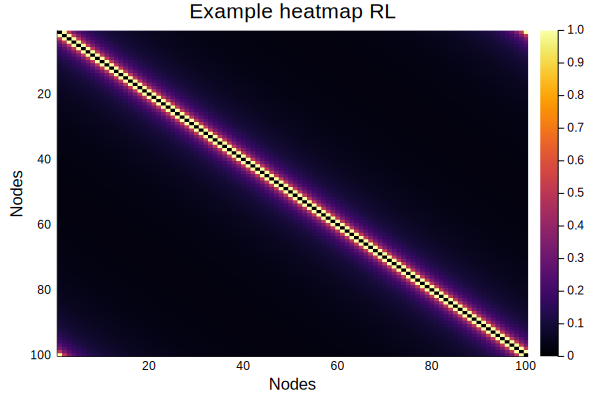

In [14]:
# Make graph model
gr()
nNodes = 100


# # IID
# adj = make_iid_weighted_graph(nNodes)

# # Plot heatmap
# heatmap(adj,yflip = true)
# title!("Example heatmap IID")
# ylabel!("Nodes")
# xlabel!("Nodes")


# # RG
# dim = 3
# adj1 = make_random_geometric(nNodes,dim)
# heatmap(adj1,yflip = true)
# title!("Example heatmap RG")
# ylabel!("Nodes")
# xlabel!("Nodes")

# # RL
# k = 2
# adj2 = make_ring_lattice_wei(20)

# heatmap(adj2,yflip = true)
# title!("Example heatmap RL")
# ylabel!("Nodes")
# xlabel!("Nodes")


# weighted rl

#adj3 = make_ring_lattice_wei(nNodes)

#heatmap(adj3,yflip = true)
#title!("Example heatmap RL_wei")
#ylabel!("Nodes")
#xlabel!("Nodes")

# adj4 = make_dot_product(nNodes,3)
# heatmap(adj4,yflip = true)
# title!("Example heatmap dot product")
# ylabel!("Nodes")
# xlabel!("Nodes")

# adj5 = make_dumb_4modular(nNodes,0.8,0.2)
# heatmap(adj5,yflip = true)
# title!("Example heatmap dumb modular")
# ylabel!("Nodes")
# xlabel!("Nodes")

# adj6 = make_dev_DiscreteUniform_configuration_model(nNodes,30,50)
# heatmap(adj6, yflip = true)
# title!("Example discrete uniform dev")
# ylabel!("Nodes")
# xlabel!("")

adj2 = make_ring_lattice_wei(nNodes)

heatmap(adj2,yflip = true)
title!("Example heatmap RL")
ylabel!("Nodes")
xlabel!("Nodes")

In [30]:
sum(adj6,dims=1)

1×20 Array{Float64,2}:
 30.0  36.0  46.0  45.0  41.0  40.0  …  31.0  35.0  43.0  42.0  38.0  45.0

In [ ]:
a = [1 2 3]
b = [1 2 a]
c = [b; b]

nNodes = 11
v = ones(1,(nNodes-1)) ./ [transpose(collect(1:floor(nNodes/2))) transpose(reverse(collect(1:floor(nNodes/2))))]
v = [0 v]

adj4 = deepcopy(v)
for n in 1:(nNodes-1)
    adj4 = [adj4; zeros(1,n) transpose(v[1,1:(nNodes-n)])]
end
adj4 = adj4+transpose(adj4)
adj4[diagind(adj4)].=0


heatmap(adj4,yflip = true)
title!("Example heatmap RL")
ylabel!("Nodes")
xlabel!("Nodes")


In [6]:
nNodes = 10
if !iseven(nNodes)
    v = ones(1,(nNodes-1)) ./ [transpose(collect(1:floor(nNodes/2))) transpose(reverse(collect(1:floor(nNodes/2))))]
    v = [0 v]
    println(v)
    adj = deepcopy(v)
    for n in 1:(nNodes-1)
        adj = [adj; zeros(1,n) transpose(v[1,1:(nNodes-n)])]
    end
    adj = adj+transpose(adj)
    adj[diagind(adj)].=0
    
else
    v = ones(1,(nNodes-1)) ./ [transpose(collect(1:(nNodes/2))) transpose(reverse(collect(1:(nNodes/2 - 1))))]
    v = [0 v]
    println(v)
    adj = deepcopy(v)
    for n in 1:(nNodes-1)
        adj = [adj; zeros(1,n) transpose(v[1,1:(nNodes-n)])]
    end
    adj = adj+transpose(adj)
    adj[diagind(adj)].=0
        
end
    
# Check for symmetry
tf = is_symmetric(adj)

# return adj
println(adj)


[0.0 1.0 0.5 0.3333333333333333 0.25 0.2 0.25 0.3333333333333333 0.5 1.0]
[0.0 1.0 0.5 0.3333333333333333 0.25 0.2 0.25 0.3333333333333333 0.5 1.0; 1.0 0.0 1.0 0.5 0.3333333333333333 0.25 0.2 0.25 0.3333333333333333 0.5; 0.5 1.0 0.0 1.0 0.5 0.3333333333333333 0.25 0.2 0.25 0.3333333333333333; 0.3333333333333333 0.5 1.0 0.0 1.0 0.5 0.3333333333333333 0.25 0.2 0.25; 0.25 0.3333333333333333 0.5 1.0 0.0 1.0 0.5 0.3333333333333333 0.25 0.2; 0.2 0.25 0.3333333333333333 0.5 1.0 0.0 1.0 0.5 0.3333333333333333 0.25; 0.25 0.2 0.25 0.3333333333333333 0.5 1.0 0.0 1.0 0.5 0.3333333333333333; 0.3333333333333333 0.25 0.2 0.25 0.3333333333333333 0.5 1.0 0.0 1.0 0.5; 0.5 0.3333333333333333 0.25 0.2 0.25 0.3333333333333333 0.5 1.0 0.0 1.0; 1.0 0.5 0.3333333333333333 0.25 0.2 0.25 0.3333333333333333 0.5 1.0 0.0]


In [5]:
#d = Normal()

d = DiscreteUniform(a,b)
# d = Geometric(p=0.1) would need to scale though



Normal{Float64}(μ=0.0, σ=1.0)

In [ ]:
a = rand(10,2)
a_norm = []
for ar in eachrow(a)
    #println(ar./norm(ar)^2)
    a_norm = [a_norm;ar./norm(ar)^2]
    #println(a_norm)
end
[vecnorm(a[:,i]) for i=1:size(a,2)]

[100, 400, 3700, 0, 0, 1600, 900, 100, 400, 1200]One node left - try again


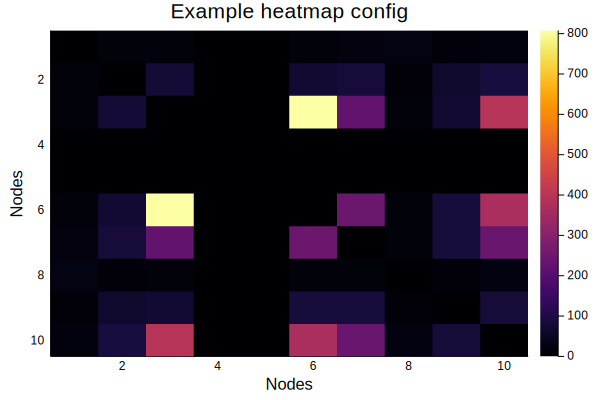

In [33]:
# configuration model
# Assume an input strength sequence
nNodes = 10

# Define distribution
#d = DiscreteUniform(10,20)
d = Geometric(0.1)
strength_sequence = 100*rand(d,nNodes)
print(strength_sequence)

stubs = deepcopy(strength_sequence)
adj = zeros(nNodes,nNodes)

nodes_left = []
# While stubs are left
while sum(stubs)>0
    
    # Find which nodes have stubs left
    nodes_left = findall(stubs.>0)
    
    # If only one node is left, we did badly
    if length(nodes_left) == 1
        println("One node left - try again")
        break
    end
    
    
    # nodes_left contains cartesian indices. Can access them with nodes_left[i][j]. Not anymore
    node1,node2 = sample(nodes_left,2, replace = false)
    
    # Add edge to adjacency matrix
    adj[node1, node2] = adj[node1, node2] + 1 
    
    # Update stubs
    stubs[node1] = stubs[node1] - 1
    stubs[node2] = stubs[node2] - 1
    
    #println("wired another!")
end

# Now we only added edges to one side of the adjacency matrix.
adj = adj+adj'

heatmap(adj,yflip = true)
title!("Example heatmap config")
ylabel!("Nodes")
xlabel!("Nodes")

    
    
    

In [21]:
sum(adj,dims =1)

1×10 Array{Float64,2}:
 18.0  17.0  18.0  17.0  12.0  14.0  19.0  12.0  18.0  15.0

In [22]:
strength_sequence


10-element Array{Int64,1}:
 18
 17
 18
 17
 12
 14
 19
 18
 18
 15